In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("../data/EURUSD_daily.csv", index_col='Date')

In [3]:
data.index = pd.to_datetime(data.index)
data.columns = ['close']

In [4]:
split_date = pd.Timestamp('01-01-2015')

In [5]:
data['log_ret'] = np.log(data.close) - np.log(data.close.shift(1))

In [6]:
data['pct_change'] = data.close.pct_change()

In [7]:
data.head(5)

,close,log_ret,pct_change
Date,,,
2000-01-03,1.0276,NaN,NaN
2000-01-04,1.0299,0.002236,0.002238
2000-01-05,1.0317,0.001746,0.001748
2000-01-06,1.0299,-0.001746,-0.001745
2000-01-07,1.0283,-0.001555,-0.001554


In [8]:
mean = data.log_ret.mean()
std = data.log_ret.std()

In [9]:
data['normalized'] = 1/(1+np.exp(-(data.log_ret-mean)/std))

In [10]:
data['5MA'] = data.normalized.rolling(5).mean()

In [11]:
data.dropna(inplace=True)

In [12]:
data_n = data.drop('close', axis=1).drop('log_ret', axis=1).drop('pct_change', axis=1)

In [13]:
train = data_n[:split_date]
test = data_n[split_date:]

In [14]:
train.count()

normalized    3909
5MA           3909
dtype: int64

In [15]:
x_train = train[:-1]
y_train = train['5MA'][1:]

x_test = test[:-1]
y_test = test['5MA'][1:]

In [16]:
x_train.count()

normalized    3908
5MA           3908
dtype: int64

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [18]:
x_train_np = x_train.values
y_train_np = y_train.values

x_test_np = x_test.values
y_test_np = y_test.values

In [19]:
x_train_t = x_train_np.reshape(x_train.shape[0], 1, 2)
x_test_t = x_test_np.reshape(x_test.shape[0], 1, 2)

In [20]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [21]:
K.clear_session()

model = Sequential()

model.add(LSTM(100, input_shape= (x_train_t.shape[1], x_train_t.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            41200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 191,951
Trainable params: 191,951
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x_train_t, y_train, epochs = 1000, batch_size=32, verbose = 1, callbacks=[early_stop])

Epoch 1/1000
3908/3908 [==============================] - 5s - loss: 0.0071     
Epoch 2/1000
3908/3908 [==============================] - 0s - loss: 0.0047     
Epoch 3/1000
3908/3908 [==============================] - 0s - loss: 0.0034     
Epoch 4/1000
3908/3908 [==============================] - 0s - loss: 0.0032     
Epoch 5/1000
3908/3908 [==============================] - 0s - loss: 0.0031     
Epoch 6/1000
3908/3908 [==============================] - 0s - loss: 0.0031     
Epoch 7/1000
3908/3908 [==============================] - 0s - loss: 0.0031     
Epoch 8/1000
3908/3908 [==============================] - 0s - loss: 0.0031     
Epoch 9/1000
3908/3908 [==============================] - 0s - loss: 0.0030     
Epoch 10/1000
3908/3908 [==============================] - 0s - loss: 0.0030     
Epoch 11/1000
3908/3908 [==============================] - 0s - loss: 0.0030     
Epoch 12/1000
3908/3908 [==============================] - 0s - loss: 0.0030     
Epoch 13/1000
3908/3908 [

In [24]:
y_pred = model.predict(x_test_t, batch_size=32)

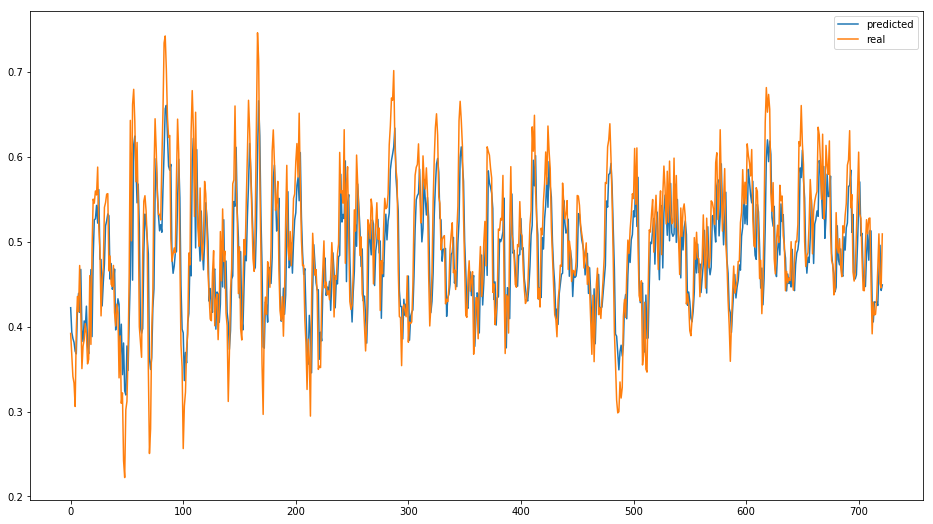

In [25]:
fig = plt.figure(figsize = (16,9))
plt.plot(y_pred)
plt.plot(y_test_np)
plt.legend(['predicted', 'real'])


In [26]:
evaluation_df = pd.DataFrame (y_pred, columns = ['predicted'])

In [27]:
evaluation_df['real'] = y_test_np

In [28]:
evaluation_df['test_x'] = x_test_np[:,1]

In [29]:
evaluation_df['predicted_move'] = (evaluation_df.predicted - evaluation_df.test_x) > 0
evaluation_df['real_move'] = (evaluation_df.real - evaluation_df.test_x) > 0

In [30]:
evaluation_df['guess_correct'] = evaluation_df.predicted_move == evaluation_df.real_move

In [31]:
evaluation_df.head(20)

,predicted,real,test_x,predicted_move,real_move,guess_correct
0,0.422422,0.392086,0.409029,True,False,False
1,0.393396,0.366916,0.392086,True,False,False
2,0.386127,0.341283,0.366916,True,False,False
3,0.381560,0.333727,0.341283,True,False,False
4,0.371154,0.306021,0.333727,True,False,False
5,0.368070,0.395491,0.306021,True,True,True
6,0.419422,0.435629,0.395491,True,True,True
7,0.439373,0.417601,0.435629,True,False,False
8,0.416933,0.472164,0.417601,False,True,False
9,0.467582,0.417783,0.472164,False,False,True


In [32]:
evaluation_df[evaluation_df['guess_correct']==False].count() / evaluation_df.count()

predicted         0.414127
real              0.414127
test_x            0.414127
predicted_move    0.414127
real_move         0.414127
guess_correct     0.414127
dtype: float64

In [33]:
evaluation_df[evaluation_df['guess_correct']==True].count() / evaluation_df.count()

predicted         0.585873
real              0.585873
test_x            0.585873
predicted_move    0.585873
real_move         0.585873
guess_correct     0.585873
dtype: float64

In [34]:
def R_squared (y_pred, y_real):
    ss_res = np.sum((y_real-y_pred)**2)
    ss_tot = np.sum((y_real-np.mean(y_real))**2)
    return 1 - (ss_res/ss_tot)

In [35]:
r_sq = R_squared(evaluation_df['predicted'], evaluation_df['real'])

In [36]:
r_sq

0.62323181856346033

In [68]:
# function reverse to sigmoid
def logit(x, mean, std):
    return np.log(x/(1-x))*std + mean

In [38]:
reverse_df = evaluation_df.drop('real_move', axis=1).drop('predicted_move', axis=1).drop('guess_correct', axis=1)

In [39]:
reverse_df.columns = ['predicted_MA', 'real_MA', 'test_step_MA']

In [40]:
reverse_df['test_step_val'] =  x_test_np[:,0]

In [41]:
for s in range(1,4):
    reverse_df['test_step-{}'.format(s)] = reverse_df.test_step_val.shift(s)

In [42]:
reverse_df['predicted_value'] = reverse_df.predicted_MA*5 - (reverse_df.test_step_val + reverse_df['test_step-1'] + reverse_df['test_step-2'] + reverse_df['test_step-3'])

In [43]:
reverse_df['real_value'] = reverse_df.real_MA*5 - (reverse_df.test_step_val + reverse_df['test_step-1'] + reverse_df['test_step-2'] + reverse_df['test_step-3'])

In [74]:
reverse_df['predicted_close_ret'] = reverse_df['predicted_value'].apply(logit,mean=mean,std=std)
reverse_df['real_close_ret'] = reverse_df['real_value'].apply(logit,mean=mean,std=std)

In [116]:
reverse_df.head(700)

,predicted_MA,real_MA,test_step_MA,test_step_val,test_step-1,test_step-2,test_step-3,predicted_value,real_value,predicted_close,predicted_close_ret,real_close_ret
0,0.422422,0.392086,0.409029,0.495526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.393396,0.366916,0.392086,0.224067,0.495526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.386127,0.341283,0.366916,0.291382,0.224067,0.495526,NaN,NaN,NaN,NaN,NaN,NaN
3,0.381560,0.333727,0.341283,0.370673,0.291382,0.224067,0.495526,0.526151,0.286988,0.000682,0.000682,-0.005647
4,0.371154,0.306021,0.333727,0.286988,0.370673,0.291382,0.224067,0.682658,0.356994,0.004806,0.004806,-0.003641
5,0.368070,0.395491,0.306021,0.356994,0.286988,0.370673,0.291382,0.534311,0.671419,0.000886,0.000886,0.004486
6,0.419422,0.435629,0.395491,0.671419,0.356994,0.286988,0.370673,0.411036,0.492069,-0.002214,-0.002214,-0.000169
7,0.439373,0.417601,0.435629,0.492069,0.671419,0.356994,0.286988,0.389394,0.280532,-0.002777,-0.002777,-0.005845
8,0.416933,0.472164,0.417601,0.280532,0.492069,0.671419,0.356994,0.283648,0.559804,-0.005749,-0.005749,0.001528
9,0.467582,0.417783,0.472164,0.559804,0.280532,0.492069,0.671419,0.334087,0.085091,-0.004273,-0.004273,-0.014783


In [107]:
pred_close_change = reverse_df['predicted_close_ret']

In [108]:
pred_close_change.dropna(inplace=True)

In [109]:
close = [100]

In [110]:
for i in range(1,pred_close_change.count()):
    close.append(close[i-1]*np.e**pred_close_change.values[i])

In [111]:
real_close_change = reverse_df['real_close_ret'].dropna()

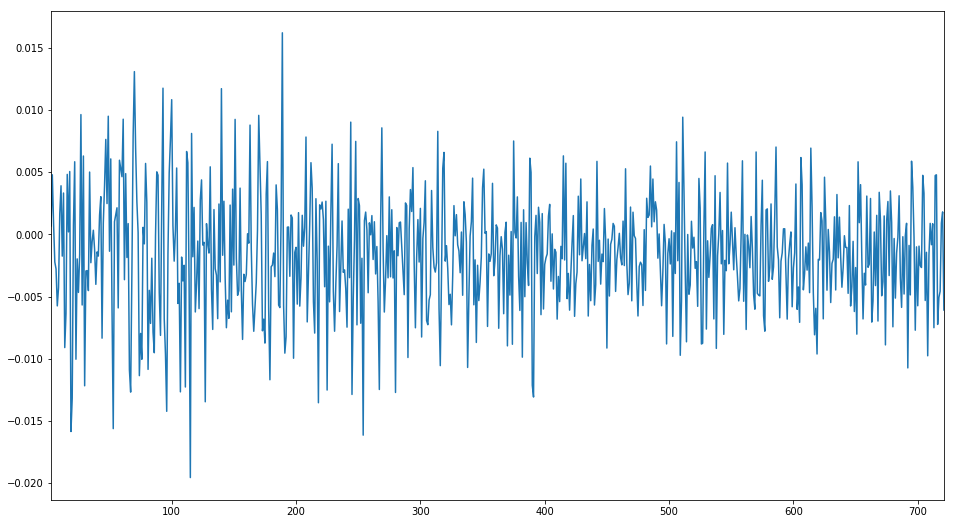

In [126]:
pred_close_change.plot(figsize=(16,9))
#real_close_change.plot()

In [112]:
close_real = [100]

In [113]:
for i in range(1,real_close_change.count()):
    close_real.append(close_real[i-1]*np.e**real_close_change.values[i])

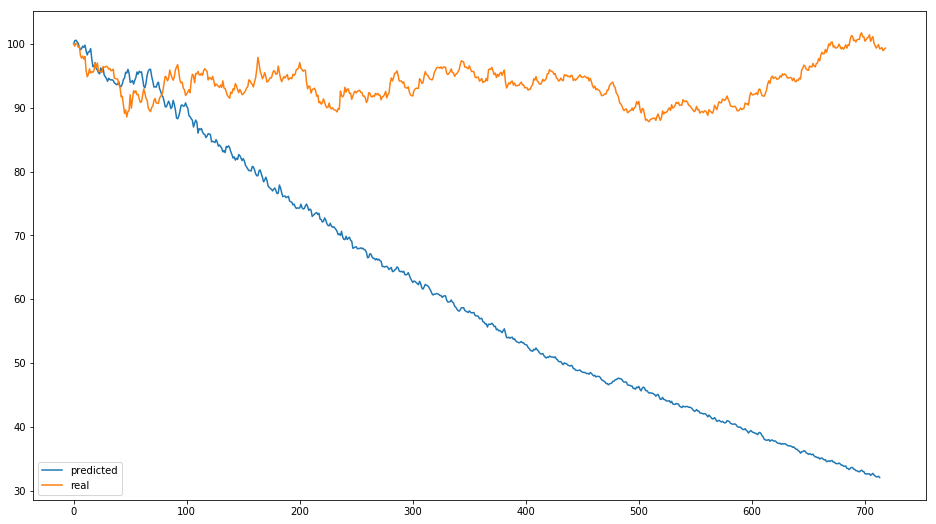

In [128]:
fig = plt.figure(figsize = (16,9))
plt.plot(close)
plt.plot(close_real)
plt.legend(['predicted', 'real'])